# Estimating Indirect Nutrient Load from PT

# Imports

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

# Helper Function 

In [2]:
# Define the function to sort the files based on the time
def sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('_')[-1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Inputs

In [3]:
# Define paths for coastal wetland shapefiles
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # Add leading slash to make it an absolute path
CW_path = os.path.join(GIS_LAYERS, 'Coastalwetland/hitshoreline')

#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'

# Paths to specific coastal wetland shapefiles with different inundation levels that have 50 meter buffer from the shoreline
CW_avg_path = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_low_path = os.path.join(CW_path, 'wetlands_connected_low_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_high_path = os.path.join(CW_path, 'wetlands_connected_high_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_surge_path = os.path.join(CW_path, 'wetlands_connected_surge_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')

# Load coastal wetland shapefiles as GeoDataFrames
CW_avg = gpd.read_file(CW_avg_path)
CW_low = gpd.read_file(CW_low_path)
CW_high = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)

# Define the path to FVCOM model output files
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output'
files = glob.glob(os.path.join(data_dir, "updated_FVCOM_Huron_*.nc"))
files.sort(key=sort_key)
# Define the path to the FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'


# Path to nutrient load data CSV and load the CSV
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/StreamWatresheds_total_N_P.csv'
Direct_Nutrient = pd.read_csv(Direct_Nutrient_load)

# Check and rename columns in the CSV file to match NetCDF data requirements
required_columns = {'Group_id': 'group_id', 'WetLoad_TN_kgcellday': 'WetLoad_TN_kgcellday', 'WetLoad_TP_kgcellday': 'WetLoad_TP_kgcellday'}

# Outputs

In [4]:
output_path = '/home/abolmaal/modelling/FVCOM/Huron/results'
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/figures'

# Define the file names to the FVCOM model output
originalFVCOM = 'LakeHuronparticletracking_2023_original.shp'


# file name for Intersected FVCOM model output with coastal wetlands

Intersection_PTCW_Avg = 'Intersections_Avg_PTCW.csv'
Intersection_PTCW_high = 'Intersections_high_PTCW.csv'
Intersection_PTCW_low = 'Intersections_low_PTCW.csv'
Intersection_PTCW_surge = 'Intersections_surge_PTCW.csv'
###################################################################
GroupIdcount = 'group_id_counts.csv'
Non_Intersection_avg = 'Non_Intersection_avg.csv'
Non_Intersection_high = 'Non_Intersection_high.csv'
Non_Intersection_low = 'Non_Intersection_low.csv'
Non_Intersection_surge = 'Non_Intersection_surge.csv'

# Parameters

In [5]:
# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface

# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'

# Main Functions


## Create a geodatafram from the particle tracking outputs

In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
from dask.delayed import delayed
import xarray as xr
from shapely.geometry import Point
import dask  # Import Dask to access dask.compute
from dask import compute  # Import the specific compute function
import gc  # To manually collect garbage and free up memory
from dask.distributed import Client


# Limit the number of workers and threads
client = Client(n_workers=2, threads_per_worker=2)  # Adjust as needed

print(client)
# Function to remove overlap in time
def remove_overlap(datasets):
    # Remove the first time step of each dataset except for the first one
    datasets[1:] = [ds.sel(time=slice(ds['time'][1], None)) for ds in datasets[1:]]
    return datasets

# Function to process a single file and convert to GeoDataFrame
@delayed
def process_file(file):
    # Open the dataset lazily with xarray (no data loaded yet)
    with xr.open_dataset(file) as ds:
        selected_vars = ds[['time', 'group_id', 'group_number', 'longitude', 'latitude']]

        # Perform operations like longitude correction
        selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                                     selected_vars['longitude'].values - 360, 
                                                     selected_vars['longitude'].values)

        # Convert xarray to pandas dataframe
        PT_df = selected_vars.to_dataframe().reset_index()

        # Create GeoDataFrame from the DataFrame
        PT_gdf = gpd.GeoDataFrame(PT_df, geometry=gpd.GeoSeries.from_xy(PT_df['longitude'], PT_df['latitude']))

        # Set the CRS and reproject if necessary
        PT_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
        PT_gdf = PT_gdf.to_crs('EPSG:3174')

        # Release memory after processing the dataset
        del ds, selected_vars, PT_df  # Delete variables no longer needed
        gc.collect()  # Force garbage collection to release memory

        return PT_gdf

# Use dask.delayed to process each file (process files in smaller batches to avoid memory overload)
batch_size = 2  # Process in smaller batches of 2 files at a time
batches = [files[i:i + batch_size] for i in range(0, len(files), batch_size)]

all_gdfs = []

# Process each batch separately
for batch in batches:
    all_delayed = [process_file(file) for file in batch]
    batch_gdfs = compute(*all_delayed)  # Use dask.compute here
    all_gdfs.extend(batch_gdfs)  # Append the GeoDataFrames from this batch

    # Manually trigger garbage collection after each batch to release memory
    gc.collect()

# Now combine the GeoDataFrames from all batches into one
final_gdf = pd.concat(all_gdfs, ignore_index=True)

# Set final CRS if necessary
#final_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
#final_gdf = final_gdf.to_crs('EPSG:3174')

# Final GeoDataFrame with all datasets
print(final_gdf)

<Client: 'tcp://127.0.0.1:37661' processes=2 threads=4, memory=15.62 GiB>
               time  particles  group_id group_number  longitude   latitude  \
0        2023-01-01          0         0        00000 -84.666107  45.742802   
1        2023-01-01          1         0        00001 -84.664886  45.742802   
2        2023-01-01          2         0        00002 -84.663696  45.742802   
3        2023-01-01          3         0        00003 -84.662506  45.742802   
4        2023-01-01          4         0        00004 -84.661285  45.742802   
...             ...        ...       ...          ...        ...        ...   
24794995 2024-01-29       8545       162       162070 -83.654114  43.605694   
24794996 2024-01-29       8546       162       162071 -83.620605  43.633438   
24794997 2024-01-29       8547       162       162072 -83.623474  43.630871   
24794998 2024-01-29       8548       162       162073 -83.645859  43.612099   
24794999 2024-01-29       8549       162       162074 -83

In [8]:
PT_gdf = final_gdf

# Calculated monthly Intersection Seperately for each month 

In [7]:
import pandas as pd
import geopandas as gpd
import gc

def calculate_monthly_first_intersections(gdf, CW_avg, output_csv="monthly_first_intersections.csv"):
    """
    Loop through each month in the dataset, find only the first intersection per particle, 
    and save the results to a single CSV file. Also calculates the percentage of 
    intersecting particles per month.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_csv: Optional output CSV filename

    Returns:
    - monthly_first_intersections_df: DataFrame of first-time intersections
    - summary_stats_df: DataFrame of intersection percentages per month
    """
    # Reset index if needed
    if 'time' in gdf.index.names:
        print("🔄 Resetting 'time' from index to column...")
        gdf = gdf.reset_index()

    if 'time' not in gdf.columns:
        print("❌ ERROR: 'time' column is missing!")
        return None, None

    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

    # Ensure CRS matches
    if gdf.crs != CW_avg.crs:
        print("🔄 Reprojecting gdf to match CW_avg CRS...")
        gdf = gdf.to_crs(CW_avg.crs)

    # Extract month
    gdf['month'] = gdf['time'].dt.to_period("M")

    # Precompute wetland union geometry
    wetland_union = CW_avg.geometry.unary_union  # Improved performance with unary_union

    # Initialize storage for results
    monthly_results = []
    summary_stats = []

    # Loop over each unique month
    unique_months = sorted(gdf['month'].unique())
    for month in unique_months:
        print(f"📅 Processing {month}...")

        monthly_gdf = gdf[gdf['month'] == month]
        total_particles = monthly_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]

        # Find intersecting particles
        intersecting_particles = monthly_gdf[monthly_gdf['geometry'].intersects(wetland_union)]

        if not intersecting_particles.empty:
            # Find the first intersection per particle (by time)
            first_intersections = (
                intersecting_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .groupby(['group_id', 'group_number'])
                .first()
                .reset_index()
            )

            total_first = first_intersections.shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ {month}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['month'] = str(month)
            monthly_results.append(first_intersections)
            summary_stats.append({'month': str(month), 'percentage': percentage})
        else:
            print(f"⚠️ {month}: No intersections found.")

        # Free memory after each month's processing
        del monthly_gdf, intersecting_particles, first_intersections
        gc.collect()

    # Combine all results
    if monthly_results:
        monthly_first_intersections_df = pd.concat(monthly_results, ignore_index=True)
    else:
        monthly_first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save to CSV
    monthly_first_intersections_df.to_csv(output_csv, index=False)
    print(f"✅ Monthly first-time intersections saved to {output_csv}")

    # Return the results
    return monthly_first_intersections_df, summary_stats_df


In [9]:
#set the crs of cw_avg to 3174
CW_avg.to_crs('EPSG:3174', inplace=True)
CW_low.to_crs('EPSG:3174', inplace=True)
CW_high.to_crs('EPSG:3174', inplace=True)
CW_surge.to_crs('EPSG:3174', inplace=True)

In [11]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_avg)


/tmp/ipykernel_1410/1415315474.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  wetland_union = CW_avg.geometry.unary_union  # Improved performance with unary_union


📅 Processing 2023-01...
✅ 2023-01: 1524 particles first-time intersected (17.82%)
📅 Processing 2023-02...
✅ 2023-02: 999 particles first-time intersected (11.68%)
📅 Processing 2023-03...
✅ 2023-03: 4030 particles first-time intersected (47.13%)
📅 Processing 2023-04...
✅ 2023-04: 3313 particles first-time intersected (38.75%)
📅 Processing 2023-05...
✅ 2023-05: 3548 particles first-time intersected (41.50%)
📅 Processing 2023-06...
✅ 2023-06: 4615 particles first-time intersected (53.98%)
📅 Processing 2023-07...
✅ 2023-07: 5310 particles first-time intersected (62.11%)
📅 Processing 2023-08...
✅ 2023-08: 5958 particles first-time intersected (69.68%)
📅 Processing 2023-09...
✅ 2023-09: 5133 particles first-time intersected (60.04%)
📅 Processing 2023-10...
✅ 2023-10: 3763 particles first-time intersected (44.01%)
📅 Processing 2023-11...
✅ 2023-11: 2614 particles first-time intersected (30.57%)
📅 Processing 2023-12...
✅ 2023-12: 2047 particles first-time intersected (23.94%)
📅 Processing 2024

In [15]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_high)


/tmp/ipykernel_1410/1415315474.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  wetland_union = CW_avg.geometry.unary_union  # Improved performance with unary_union


📅 Processing 2023-01...
✅ 2023-01: 1553 particles first-time intersected (18.16%)
📅 Processing 2023-02...
✅ 2023-02: 1035 particles first-time intersected (12.11%)
📅 Processing 2023-03...
✅ 2023-03: 4319 particles first-time intersected (50.51%)
📅 Processing 2023-04...
✅ 2023-04: 3710 particles first-time intersected (43.39%)
📅 Processing 2023-05...
✅ 2023-05: 3920 particles first-time intersected (45.85%)
📅 Processing 2023-06...
✅ 2023-06: 4943 particles first-time intersected (57.81%)
📅 Processing 2023-07...
✅ 2023-07: 5500 particles first-time intersected (64.33%)
📅 Processing 2023-08...
✅ 2023-08: 6264 particles first-time intersected (73.26%)
📅 Processing 2023-09...
✅ 2023-09: 5500 particles first-time intersected (64.33%)
📅 Processing 2023-10...
✅ 2023-10: 4083 particles first-time intersected (47.75%)
📅 Processing 2023-11...
✅ 2023-11: 2724 particles first-time intersected (31.86%)
📅 Processing 2023-12...
✅ 2023-12: 2065 particles first-time intersected (24.15%)
📅 Processing 202

In [18]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_low)


/tmp/ipykernel_1410/1415315474.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  wetland_union = CW_avg.geometry.unary_union  # Improved performance with unary_union


📅 Processing 2023-01...
✅ 2023-01: 1434 particles first-time intersected (16.77%)
📅 Processing 2023-02...
✅ 2023-02: 888 particles first-time intersected (10.39%)
📅 Processing 2023-03...
✅ 2023-03: 3645 particles first-time intersected (42.63%)
📅 Processing 2023-04...
✅ 2023-04: 2925 particles first-time intersected (34.21%)
📅 Processing 2023-05...
✅ 2023-05: 3132 particles first-time intersected (36.63%)
📅 Processing 2023-06...
✅ 2023-06: 4176 particles first-time intersected (48.84%)
📅 Processing 2023-07...
✅ 2023-07: 4891 particles first-time intersected (57.20%)
📅 Processing 2023-08...
✅ 2023-08: 5426 particles first-time intersected (63.46%)
📅 Processing 2023-09...
✅ 2023-09: 4615 particles first-time intersected (53.98%)
📅 Processing 2023-10...
✅ 2023-10: 3395 particles first-time intersected (39.71%)
📅 Processing 2023-11...
✅ 2023-11: 2464 particles first-time intersected (28.82%)
📅 Processing 2023-12...
✅ 2023-12: 2031 particles first-time intersected (23.75%)
📅 Processing 2024

In [19]:
import matplotlib.pyplot as plt

def plot_monthly_intersection_barchart(summary_df, title="Monthly % of First-Time Intersections"):
    """
    Creates a bar chart showing the percentage of particles that intersected 
    the coastal wetland for the first time each month.

    Parameters:
    - summary_df: DataFrame with 'month' and 'percentage' columns
    - title: Title for the plot

    Returns:
    - None (displays the plot)
    """
    # Ensure the data is sorted by month
    summary_df = summary_df.sort_values(by="month")

    # Plot setup
    plt.figure(figsize=(12, 6))
    bars = plt.bar(summary_df["month"], summary_df["percentage"], color='skyblue', edgecolor='black')

    # Annotate each bar with the percentage
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", 
                 ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.ylabel("Intersection Percentage (%) ", fontsize=12)
    plt.xlabel("Month", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_figures + '/Monthly_First_Time_Intersections_low_particlemiddleplume.png')
    plt.show()



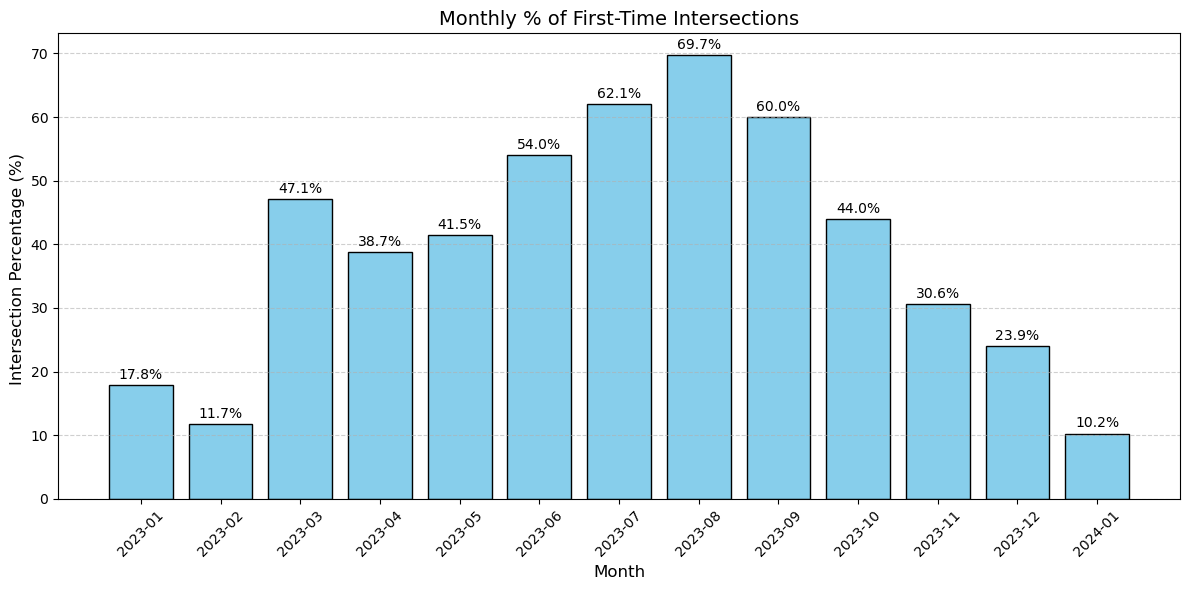

In [14]:
plot_monthly_intersection_barchart(monthly_percentages_df)


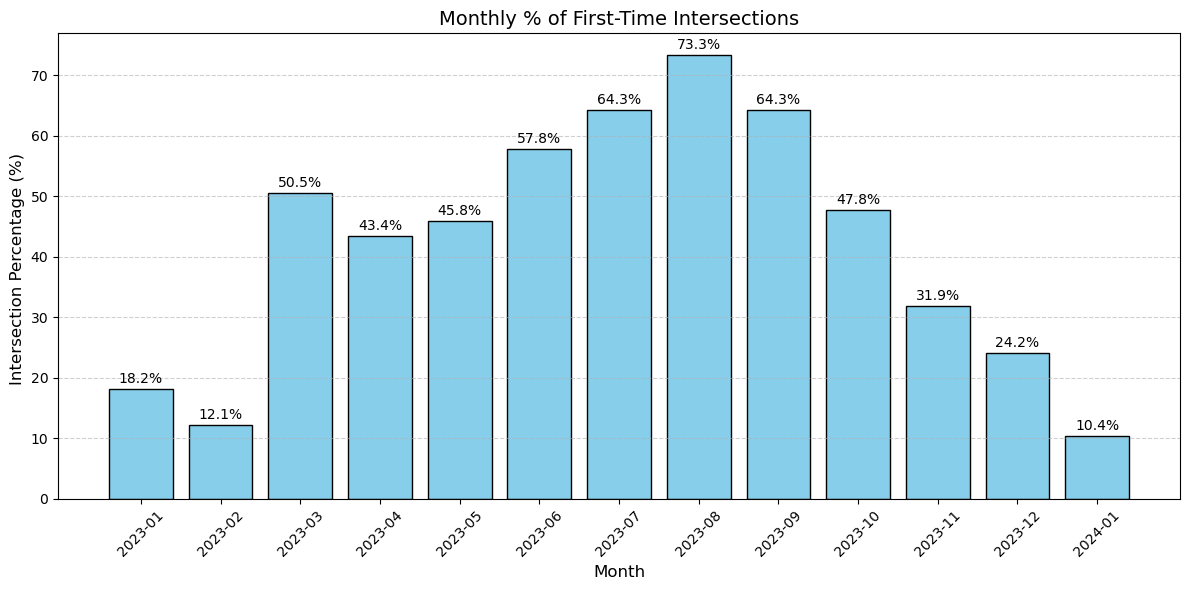

In [17]:
plot_monthly_intersection_barchart(monthly_percentages_df)


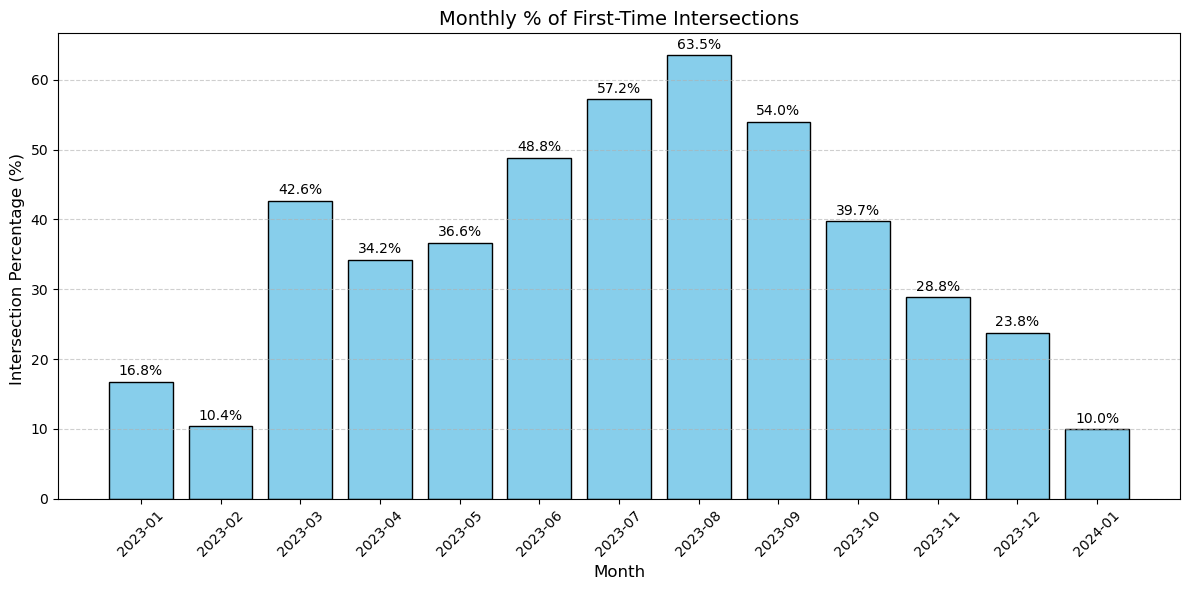

In [20]:
plot_monthly_intersection_barchart(monthly_percentages_df)
